# Variability and coexpression of ISGs at baseline

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [6]:
adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [8]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
adata.shape

(69958, 36588)

In [10]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [11]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Define ISG classes

In [12]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [13]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0]

In [15]:
cytokines = pd.read_csv('mart_export.txt')['Gene name'].tolist()
# cytokines = v_df.query('cytokine').gene.tolist()

### Setup memento

In [16]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [17]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [18]:
memento.setup_memento(adata, q_column='q', trim_percent=0.05)

Version 0.0.6


### Variability of DEGs in control cells

In [19]:
m_list, v_list = [], []
for ct in ['C', 'B', 'BC']:
    ctrl = adata[(adata.obs.stim=='control') & adata.obs.ct.isin([ct])].copy().copy()
    ctrl.obs['group'] = 1
    memento.create_groups(ctrl, label_columns=['group', 'ct'])
    memento.compute_1d_moments(ctrl, min_perc_group=.9) 
    
    m_df, v_df = memento.get_1d_moments(ctrl, groupby='group')
    
    v_df['cytokine'] = v_df['gene'].apply(lambda x: 'cytokine' if x in cytokines else 'rest')
    v_df = v_df.merge(isg_classes[['gene', 'overall_type']], on='gene', how='left').fillna('rest')
    m_df['ct'] = ct
    v_df['ct'] = ct
    
    m_list.append(m_df.copy())
    v_list.append(v_df.copy())
m_df = pd.concat(m_list)
v_df = pd.concat(v_list)
v_df['is_isg'] = v_df['overall_type'].apply(lambda x: 'ISG' if x != 'rest' else 'rest')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


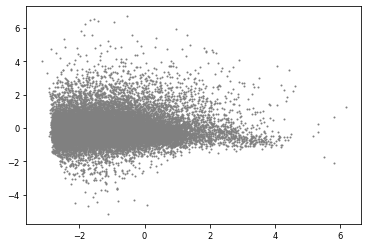

In [20]:
plt.scatter(m_df['group_1'], v_df['group_1'], s=1, color='gray')
# plt.plot([-3, 5], [0, 0])
# plt.scatter(m_df.query('gene in @t1_isg')['group_1'], v_df.query('gene in @t1_isg')['group_1'], s=5, linewidth=1, color='k')


In [31]:
overlap = v_df.query('is_isg !="rest" & cytokine != "rest"').copy()
overlap['gene_class'] = 'cytokine'

In [32]:
def classify(row):
    
    if row['is_isg'] == 'ISG':
        return 'ISG'
    elif row['cytokine'] == 'cytokine':
        return 'cytokine'
    else:
        return 'rest'

In [33]:
v_df['gene_class'] = v_df.apply(classify, axis=1)

In [34]:
barplot_df = pd.concat([v_df, overlap])

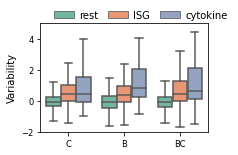

In [39]:
plt.figure(figsize=(3,2))
sns.boxplot(x='ct', y='group_1', hue='gene_class', data=v_df, fliersize=0.0, palette='Set2')
# sns.stripplot(x='ct', y='group_1', hue='overall_type', data=v_df)

plt.legend(bbox_to_anchor=(0.6,1.2), frameon=False, title=None, ncol=3, loc='upper center', handletextpad=0.5, columnspacing=1); 
plt.ylabel('Variability'); plt.xlabel(None)
plt.ylim(-2,5)
plt.savefig('isg_cytokine_var_baseline.pdf', bbox_inches='tight')

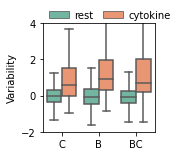

In [242]:
plt.figure(figsize=(2,2))
sns.boxplot(x='ct', y='group_1', hue='cytokine', data=v_df, fliersize=0.0, palette='Set2')
# sns.stripplot(x='ct', y='group_1', hue='overall_type', data=v_df)

plt.legend(bbox_to_anchor=(0.6,1.2), frameon=False, title=None, ncol=2, loc='upper center', handletextpad=0.5, columnspacing=1); 
plt.ylabel('Variability'); plt.xlabel(None)
plt.ylim(-2,4)
plt.savefig('cytokine_var_baseline.pdf', bbox_inches='tight')

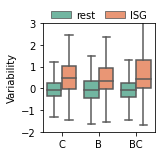

In [243]:
plt.figure(figsize=(2,2))
sns.boxplot(x='ct', y='group_1', hue='is_isg', data=v_df, fliersize=0.0, palette='Set2')
# sns.stripplot(x='ct', y='group_1', hue='overall_type', data=v_df)

plt.legend(bbox_to_anchor=(0.5,1.2), frameon=False, title=None, ncol=2, loc='upper center', handletextpad=0.5, columnspacing=1);  
plt.ylabel('Variability'); plt.xlabel(None)
plt.ylim(-2,3)
plt.savefig('isg_var_baseline.pdf', bbox_inches='tight')

### Find a UMAP example

In [244]:
a = v_df.merge(m_df[['gene', 'ct', 'group_1']], on=['gene', 'ct'])

In [245]:
a.head(2)

,gene,group_1_x,cytokine,overall_type,ct,is_isg,group_1_y
0,LINC01409,-0.407427,rest,rest,C,rest,-2.098146
1,FAM41C,-0.482366,rest,rest,C,rest,-2.235191


In [246]:
adata_processed.obs['is_control'] = (adata_processed.obs['stim']=='control').astype(int)

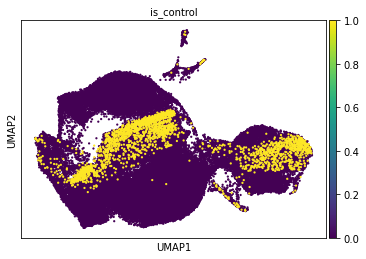

In [247]:
sc.pl.umap(adata_processed, color='is_control', s=20)

In [248]:
adata_ctrl = adata_processed[adata_processed.obs.stim=='control'].copy()
sc.tl.umap(adata_ctrl)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


### Heatmap for correlations at baseline

In [249]:
ct = 'C'
ctrl = adata[(adata.obs.stim=='control') & adata.obs.ct.isin([ct])].copy().copy()
ctrl.obs['group'] = 1
memento.create_groups(ctrl, label_columns=['group', 'ct'])
memento.compute_1d_moments(ctrl, min_perc_group=.9) 

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [250]:
included_de_genes = list(set(t1_isg+t2_isg+shared_isg) & set(ctrl.var.index))

In [251]:
memento.compute_2d_moments(ctrl, gene_pairs=list(itertools.combinations(included_de_genes,2)))
c_df = memento.get_2d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [252]:
ct_c_df = c_df[['gene_1', 'gene_2', 'ct_C']]
ct_heatmap = pd.DataFrame(np.zeros((len(included_de_genes), len(included_de_genes))), columns=included_de_genes, index=included_de_genes)
for idx, row in ct_c_df.iterrows():
    
    ct_heatmap.loc[row['gene_1'], row['gene_2']] = row['ct_C']
    ct_heatmap.loc[row['gene_2'], row['gene_1']] = row['ct_C']

In [267]:
print(ct_heatmap.shape)
cg = sns.clustermap(ct_heatmap.fillna(0.0), center=0, vmax=0.3, metric=''); plt.close()
row_inds = cg.dendrogram_row.reordered_ind
col_inds = cg.dendrogram_col.reordered_ind
print(ct_heatmap.shape)


(376, 376)
(376, 376)


In [268]:
def classify_color(x):
    
    if x in shared_isg:
        return -1
    if x in t1_isg:
        return 0
    if x in t2_isg:
        return 1
    return 'impossible'

In [269]:
# class_list = np.array([classify(g) for g in included_de_genes])[:, np.newaxis]

In [270]:
from matplotlib.colors import LinearSegmentedColormap


myColors = sns.color_palette('husl')[:3]
class_list = np.array([classify_color(g) for g in included_de_genes])[np.newaxis, :]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

In [279]:
'ISG15' in included_de_genes

True

In [282]:
ct_heatmap.index.get_loc(g)

NameError: name 'g' is not defined

In [289]:
row_inds.indexof(ct_heatmap.index.get_loc(g))

AttributeError: 'list' object has no attribute 'indexof'

In [293]:
g = 'ISG15'
np.where(np.array(row_inds)==ct_heatmap.index.get_loc(g))[0][0]

299

In [352]:
for i in selected_genes[5]:
    print(i)

NCF1
IL32
PDP1
DUOX2
HLA-DMB
PMAIP1
HLA-DQB1
HLA-DRB5
HLA-DQA2
HLA-DQA1
CFB
APOD
GSTK1
PSME1
PLAAT4
B2M
HLA-F
HLA-A
HLA-C
HLA-B
SOD2
HLA-DPB1
HLA-DMA
HLA-DPA1
HLA-DRB1
HLA-DRA
CD74
PALM2-AKAP2


In [316]:
colors = sns.color_palette('husl')

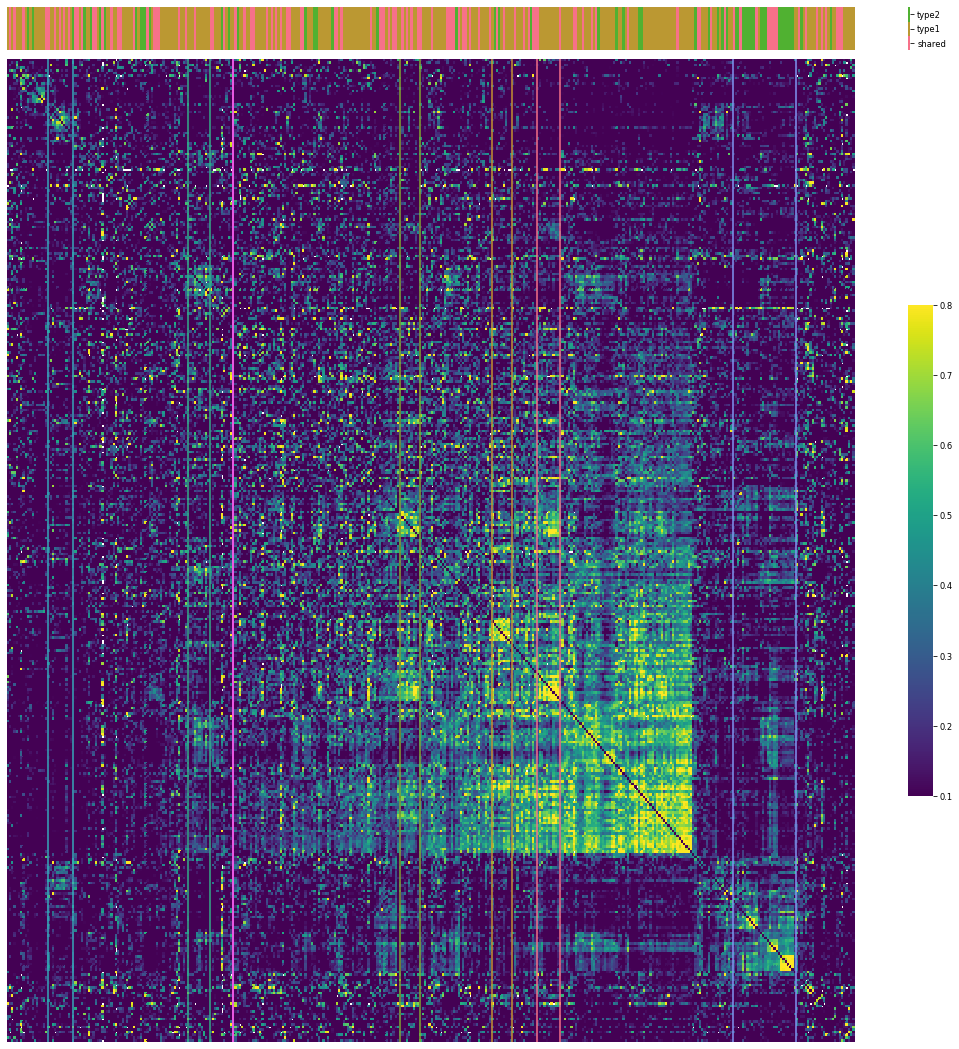

In [353]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((21,20), (1,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((21,20), (0,0), colspan=19, rowspan=1)

sns.heatmap(ct_heatmap.iloc[row_inds, col_inds], cmap='viridis', vmax=0.8, vmin=0.1, ax=ax1, yticklabels=False, xticklabels=False, cbar_kws={"shrink": 0.5})
sns.heatmap(class_list[:, row_inds], cmap=cmap, ax=ax2, yticklabels=False, xticklabels=False,)
colorbar = ax2.collections[0].colorbar
colorbar.set_ticks([-0.66, 0,0.66,])
colorbar.set_ticklabels(['shared', 'type1', 'type2'])

# some_genes = list(set(['ISG15', 'MX1', 'IFIT3', 'OAS1', 'OAS2', 'OASL', 'MX2', 'IFI6', 'STAT1'])&set(included_de_genes))
# for g in some_genes:
#     idx = np.where(np.array(row_inds)==ct_heatmap.index.get_loc(g))[0][0]
#     ax1.plot([0, len(included_de_genes)], [idx, idx], color='magenta')
#     ax1.plot([idx, idx],[0, len(included_de_genes)], color='magenta',)
    
selected_genes = {}
locations = [
    (235, 245),
    (215, 224),
    (174, 183),
    (80, 90),
    (18, 29),
    (322, 350),
    (100, 100)
]
colors = sns.color_palette('husl', len(locations))
i = 0

for x1, x2 in locations:
    
    ax1.plot([x1, x1],[0, len(included_de_genes)], color=colors[i],)
    ax1.plot([x2, x2],[0, len(included_de_genes)], color=colors[i])

    selected_genes[i]= ct_heatmap.index[np.array(row_inds)[x1:x2]]
    
    i+=1

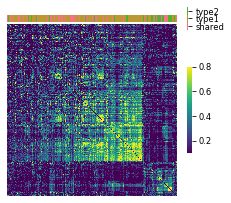

In [357]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(4,3.5))
ax1 = plt.subplot2grid((21,20), (1,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((21,20), (0,0), colspan=19, rowspan=1)

sns.heatmap(ct_heatmap.iloc[row_inds[100:355], col_inds[100:355]], cmap='viridis', vmax=0.8, vmin=0.1, ax=ax1, yticklabels=False, xticklabels=False, cbar_kws={"shrink": 0.5})
sns.heatmap(class_list[:, row_inds[100:355]], cmap=cmap, ax=ax2, yticklabels=False, xticklabels=False, cbar_kws={"shrink": 3})
colorbar = ax2.collections[0].colorbar
colorbar.set_ticks([-0.66, 0,0.66,])
colorbar.set_ticklabels(['shared', 'type1', 'type2'])
plt.savefig('baseline_isg_corr.png', dpi=800, bbox_inches='tight')

### Compare correlation to random genes

In [421]:
ct = 'C'
ctrl = adata[(adata.obs.stim=='control') & adata.obs.ct.isin([ct])].copy().copy()
ctrl.obs['group'] = 1
memento.create_groups(ctrl, label_columns=['group', 'ct'])
memento.compute_1d_moments(ctrl, min_perc_group=.9) 

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [446]:
included_de_genes = list(set(t1_isg+t2_isg+shared_isg) & set(ctrl.var.index))

In [447]:
memento.compute_2d_moments(ctrl, gene_pairs=list(itertools.combinations(included_de_genes,2)))
c_df = memento.get_2d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [451]:
ctrl.var.index.shape

(11030,)

In [ ]:
list(zip(np.random.choice(ctrl.var.index, 1000), np.random.choice(ctrl.var.indexm, 1000)))

In [453]:
# memento.compute_2d_moments(ctrl, gene_pairs=list(itertools.combinations(np.random.choice(ctrl.var.index, size=len(included_de_genes), replace=False),2)))
memento.compute_2d_moments(ctrl, gene_pairs=list(zip(np.random.choice(ctrl.var.index, 1000), np.random.choice(ctrl.var.index, 1000))))

random_c_df = memento.get_2d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [458]:
c_df['which'] = 'between ISG'
random_c_df['which'] = 'random'

In [459]:
comb = pd.concat([c_df, random_c_df])

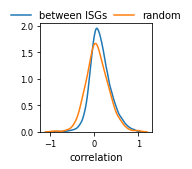

In [474]:
plt.figure(figsize=(2,2))

sns.kdeplot(c_df['ct_C'])
sns.kdeplot(random_c_df['ct_C'])
plt.xlabel('correlation')
plt.ylabel(None); 
plt.legend(['between ISGs', 'random'], frameon=False, loc='upper center', bbox_to_anchor=(0.5,1.2), ncol=2, columnspacing=0.7)

### Correlation to TFs

In [359]:
tf_df = pd.read_csv('human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA']

In [365]:
adata_stim

AnnData object with n_obs × n_vars = 0 × 36588
    obs: 'NUM.SNPS', 'BEST.GUESS', 'DROPLET.TYPE', 'batch', 'HTO_classification', 'condition', 'donor', 'stim', 'time', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'ct', 'q', 'memento_size_factor', 'time_step', 'memento_group'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'memento'

In [366]:
adata

AnnData object with n_obs × n_vars = 69958 × 36588
    obs: 'NUM.SNPS', 'BEST.GUESS', 'DROPLET.TYPE', 'batch', 'HTO_classification', 'condition', 'donor', 'stim', 'time', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'ct', 'q', 'memento_size_factor'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'memento'

In [376]:
stim = 'control'
ct = 'C'
adata_stim = adata.copy()[

    adata.obs.ct.isin([ct]) & \
    adata.obs.stim.isin([stim])].copy()
adata_stim.obs['group'] = 1

memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)

available_tfs = list(set(tf_list) & set(adata_stim.var.index))
available_isgs= list(set(t1_isg+t2_isg+shared_isg) & set(adata_stim.var.index))

# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))
corr_df = memento.get_2d_moments(adata_stim, groupby='group')

In [401]:
avg_corr = corr_df.groupby('gene_1')['group_1'].mean().sort_values(ascending=False).reset_index(name='corr')

In [ ]:
avg_corr = corr_df.groupby('gene_1')['group_1'].mean().sort_values(ascending=False).reset_index(name='corr')
for idx, row in avg_corr.iterrows():
    plt.plot([idx, idx], [0, row['corr']], color='k', lw=1)
# sns.barplot(x='gene_1', y='corr', data=corr_df.groupby('gene_1')['group_1'].mean().reset_index(name='corr'));
plt.xticks([], []); plt.xlabel('Transcriptional regulator'); plt.ylabel('Avg. corr with ISGs at baseline')

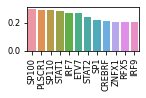

In [420]:
plt.figure(figsize=(2,0.8))

avg_corr = corr_df.groupby('gene_1')['group_1'].mean().sort_values(ascending=False).reset_index(name='corr').head(12)
sns.barplot(x='gene_1', y='corr', data=avg_corr);
plt.xticks(rotation=90)
plt.xlabel(None); plt.ylabel(None)
plt.savefig('baseline_tf_isg_corr_zoom.pdf', bbox_inches='tight')

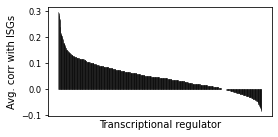

In [419]:
avg_corr = corr_df.groupby('gene_1')['group_1'].mean().sort_values(ascending=False).reset_index(name='corr')

plt.figure(figsize=(4,2))
for idx, row in avg_corr.iterrows():
    plt.plot([idx, idx], [0, row['corr']], color='k', lw=0.5)
# sns.barplot(x='gene_1', y='corr', data=corr_df.groupby('gene_1')['group_1'].mean().reset_index(name='corr'));
plt.xticks([], []); plt.xlabel('Transcriptional regulator'); plt.ylabel('Avg. corr with ISGs')
plt.savefig('baseline_tf_isg_corr.png', dpi=800, bbox_inches='tight')

### STAT1 binding site enrichment

In [103]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [104]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python

In [119]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [120]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

In [121]:
# Having a binding site makes you more variable at baseline
v_df['tss_binding'] = v_df['gene'].isin(isgf3_genes)
v_df['deg_type'] = v_df['class'].astype(str).apply(lambda x: {
    'uniq_gamma':'uniq\ntype II', 'uniq_alpha/beta':'uniq\ntype I', 'uniq_lambda':'uniq\ntype III', 'partially_shared':'partial', 'shared':'shared', 'none-DE':'non-DE'}[x])

Text(0, 0.5, 'Proportion with ISGF3 \nbinding site in TSS')

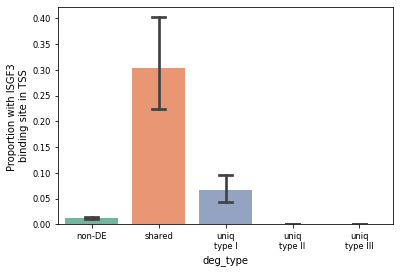

In [122]:
sns.barplot(x='deg_type', y='tss_binding', data=v_df[v_df['deg_type']!='partial'].sort_values('deg_type'), capsize=0.2, palette='Set2');
plt.ylabel('Proportion with ISGF3 \nbinding site in TSS')
# plt.xticks([0, 1, 2, 3, 4], ['none\nDE', 'shared','type III', 'type II', 'type I']);

In [123]:
v_df.head(2)

,gene,ct_C,ct_BC,ct_B,de,class,tss_binding,deg_type
0,LINC01409,0.096451,0.448388,0.107916,False,none-DE,False,non-DE
1,FAM41C,-0.157768,-0.038260,-0.144266,False,none-DE,False,non-DE


In [124]:
stats.mannwhitneyu(v_df.query('tss_binding').ct_C, v_df.query('~tss_binding').ct_C)

MannwhitneyuResult(statistic=1023299.0, pvalue=5.8263460482996915e-05)

(-2.0, 2.0)

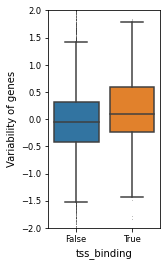

In [125]:
plt.figure(figsize=(2,4))
sns.boxplot(x='tss_binding', y='ct_BC', data=v_df, fliersize=0.1); plt.ylabel('Variability of genes')
plt.ylim(-2, 2)